# Impact Studies Using SuPy

## Aim

In this tutorial, we aim to perform sensitivity analysis using `supy` in a parallel mode to investigate the impacts on urban climate of

1. surface properties: the physical attributes of land covers (e.g., albedo, water holding capacity, etc.)
2. background climate: longterm meteorological conditions (e.g., air temperature, precipitation, etc.)



## Prepare `supy` for the parallel mode

### load `supy` and sample dataset

In [1]:
from dask import delayed
from dask import dataframe as dd
import os
import supy as sp
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from time import time

get_ipython().run_line_magic('matplotlib', 'inline')
# produce high-quality figures, which can also be set as one of ['svg', 'pdf', 'retina', 'png']
# 'svg' produces high quality vector figures
%config InlineBackend.figure_format = 'svg'
# show supy version info
sp.show_version()

supy: 2019.6.8 
supy_driver: 2018c8


In [2]:
# load sample datasets
df_state_init, df_forcing = sp.load_SampleData()
# perform an example run to get output samples for later use
df_output, df_state_final = sp.run_supy(df_forcing, df_state_init)


### Paralell setup for `supy` using `dask`

Given the nature of impact studies that requires multiple independent models with selected parameters/variables varying across the setups, such simulations well fall into the scope of so-called [*embarrassingly parallel computation*](http://docs.dask.org/en/latest/use-cases.html#embarrassingly-parallel-computation) that is fully supported by `dask`. Also, as `supy` is readily built on the data structure `pandas.DataFrame`, we can fairly easily transfer it to the `dask` framework for parallel operations thanks to [`dask.dataframe`](http://docs.dask.org/en/latest/dataframe.html), a specialized `dataframe` extending `pandas.DataFrame`'s ability in parallel operations.

Prior to version 2019.5, for a given forcing dataset `df_forcing`, `supy` would loop over the grids in a `df_state_init` to conduct simulations. Since version 2019.5, `supy` has been using the `dask.dataframe` to gain the parallel benefits through its parallelized `apply` method.

`dask.dataframe` essentially divides the work into pieces for parallel operations. As such, depending on the number of processors in your computer, it would be more efficient to set the partition number as the multipliers of CPU numbers.

In [3]:
import platform
import psutil
list_info=['machine','system','mac_ver','processor']
for info in list_info:
    info_x=getattr(platform,info)()
    print(info,':',info_x)
cpu_count=psutil.cpu_count()
print('number of CPU processors:',cpu_count)
mem_size=psutil.virtual_memory().total/1024**3
print('memory size (GB):',mem_size)

machine : x86_64
system : Darwin
mac_ver : ('10.14.4', ('', '', ''), 'x86_64')
processor : i386
number of CPU processors: 12
memory size (GB): 32.0


To demonstrate the parallelization, we simply duplicate the contents in `df_state_init` to make it seemingly large. Note we intentionally choose `24` as the number for copies to accompany the power of CPU.

Before we move on to the parallel mode, we perform a simulation in the traditional serial way to see the baseline performance.

#### Baseline serial  run

In [4]:
# just run for 30 days
df_forcing_part = df_forcing.iloc[:288*30]
df_state_init_mgrids = df_state_init.copy()
# construct a multi-grid `df_state_init`
for i in range(24-1):
    df_state_init_mgrids = df_state_init_mgrids.append(
        df_state_init, ignore_index=True)
# perform a serial run
t0 = time()
for i in range(24-1):
    xx = sp.run_supy(df_forcing_part, df_state_init_mgrids.iloc[[i]])
t1 = time()
t_ser = t1-t0
print(f'Execution time: {t_ser:.2f} s')


Execution time: 31.88 s


#### Parallel  run

In [5]:
# parallel run is enabled in supy by default
t0 = time()
xx = sp.run_supy(df_forcing_part, df_state_init_mgrids)
t1 = time()
t_par = t1-t0
print(f'Execution time: {t_par:.2f} s')

Execution time: 8.59 s


#### Benchmark test

*Note: this test may take a considerably long time depending on the machine performance*

In [6]:
# different running length
list_sim_len = [
    day * 288 for day in [30, 90, 120, 150, 180, 270, 365, 365 * 2, 365 * 3]
]

# number of test grids
n_grid = 12

# construct a multi-grid `df_state_init`
df_state_init_m = df_state_init.copy()
for i in range(n_grid - 1):
    df_state_init_m = df_state_init_m.append(df_state_init, ignore_index=True)

# construct a longer`df_forcing` for three years
df_forcing_m = pd.concat([df_forcing for i in range(3)])
df_forcing_m.index = pd.date_range(df_forcing.index[0],
                                   freq=df_forcing.index.freq,
                                   periods=df_forcing_m.index.size)

dict_time_ser = dict()
dict_time_par = dict()
for sim_len in list_sim_len:
    df_forcing_part = df_forcing_m.iloc[:sim_len]
    print('Sim days:', sim_len / 288)
    print('No. of grids:', df_state_init_m.shape[0])
    # serial run
    print('serial:')
    t0 = time()
    for i in range(df_state_init_m.shape[0]):
        sp.run_supy(df_forcing_part, df_state_init_m.iloc[[i]])
    t1 = time()
    t_test = t1 - t0
    print(f'Execution time: {t_test:.2f} s')
    #     print()
    dict_time_ser.update({sim_len: t_test})

    # parallel run
    print('parallel:')
    t0 = time()
    sp.run_supy(df_forcing_part, df_state_init_m)
    t1 = time()
    t_test = t1 - t0
    print(f'Execution time: {t_test:.2f} s')
    print()
    dict_time_par.update({sim_len: t_test})

Sim days: 30.0
No. of grids: 12
serial:
Execution time: 16.66 s
parallel:
Execution time: 4.83 s

Sim days: 90.0
No. of grids: 12
serial:
Execution time: 47.56 s
parallel:
Execution time: 13.11 s

Sim days: 120.0
No. of grids: 12
serial:
Execution time: 59.75 s
parallel:
Execution time: 17.03 s

Sim days: 150.0
No. of grids: 12
serial:
Execution time: 75.88 s
parallel:
Execution time: 21.21 s

Sim days: 180.0
No. of grids: 12
serial:
Execution time: 89.50 s
parallel:
Execution time: 26.77 s

Sim days: 270.0
No. of grids: 12
serial:
Execution time: 134.00 s
parallel:
Execution time: 39.63 s

Sim days: 365.0
No. of grids: 12
serial:
Execution time: 174.84 s
parallel:
Execution time: 53.04 s

Sim days: 730.0
No. of grids: 12
serial:
Execution time: 347.02 s
parallel:
Execution time: 118.87 s

Sim days: 1095.0
No. of grids: 12
serial:
Execution time: 515.71 s
parallel:
Execution time: 184.12 s



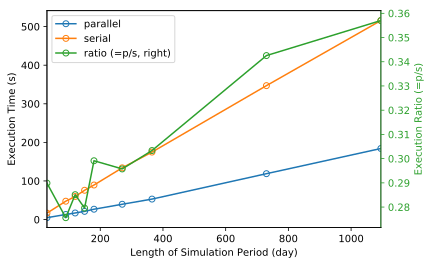

In [14]:
df_benchmark = pd.DataFrame([
    dict_time_par,
    dict_time_ser])\
.transpose()\
.rename(columns={0: 'parallel', 1: 'serial'})
idx_bmk = (df_benchmark.index / 288).astype(int)
df_benchmark.index = idx_bmk.set_names('Length of Simulation Period (day)')

# calculate execution time ratio between parallel and serial runs
ser_ratio = df_benchmark['parallel'] / df_benchmark['serial']
df_benchmark = df_benchmark.assign(ratio=ser_ratio)\
    .rename(columns={'ratio': 'ratio (=p/s, right)'})

# show executation times and ratio on plot
ax = df_benchmark.plot(secondary_y='ratio (=p/s, right)',
                       marker='o',
                       fillstyle='none')
ax.set_ylabel('Execution Time (s)')

lines = ax.get_lines() + ax.right_ax.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='best')

ax.right_ax.set_ylabel('Execution Ratio (=p/s)', color='C2')
ax.right_ax.spines['right'].set_color('C2')
ax.right_ax.tick_params(axis='y', colors='C2')

## Surface properties: surface albedo

### Examine the default albedo values loaded from the sample dataset

In [3]:
df_state_init.alb


ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
98,0.12,0.15,0.12,0.18,0.21,0.21,0.1


### Copy the initial condition `DataFrame`  to have a *clean slate* for our study

Note: `DataFrame.copy()` defaults to `deepcopy`

In [4]:
df_state_init_test = df_state_init.copy()


### Set the `Bldg` land cover to 100% for this study

In [5]:
df_state_init_test.sfr = 0
df_state_init_test.loc[:, ('sfr', '(1,)')] = 1
df_state_init_test.sfr


ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
98,0,1,0,0,0,0,0


### Construct a `df_state_init_x` dataframe to perform `supy` simulation with specified albedo

In [6]:
# create a `df_state_init_x` with different surface properties
n_test = 48
list_alb_test = np.linspace(0.1, 0.8, n_test).round(2)
df_state_init_x = df_state_init_test.append(
    [df_state_init_test]*(n_test-1), ignore_index=True)

# here we modify surface albedo
df_state_init_x.loc[:, ('alb', '(1,)')] = list_alb_test


### Conduct simulations with `supy`

In [7]:
df_forcing_part = df_forcing.loc['2012 01':'2012 07']
df_res_alb_test,df_state_final_x = sp.run_supy(df_forcing_part, df_state_init_x)

### Examine the simulation results

In [8]:
# choose results of July 2012 for analysis
df_res_alb_test_july=df_res_alb_test.SUEWS.unstack(0).loc['2012 7']
df_res_alb_T2_stat = df_res_alb_test_july.T2.describe()
df_res_alb_T2_diff = df_res_alb_T2_stat.transform(
    lambda x: x - df_res_alb_T2_stat.iloc[:, 0])
df_res_alb_T2_diff.columns = list_alb_test-list_alb_test[0]

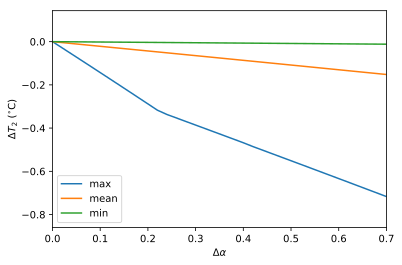

In [9]:
ax_temp_diff = df_res_alb_T2_diff.loc[['max', 'mean', 'min']].T.plot()
ax_temp_diff.set_ylabel('$\Delta T_2$ ($^{\circ}}$C)')
ax_temp_diff.set_xlabel(r'$\Delta\alpha$')
ax_temp_diff.margins(x=0.2, y=0.2)

### Why a bi-linear $\Delta \alpha-\Delta T_{2,max}$ relationship?

Although the relations for mean and minimum $T_2$ demonstrate single linear patterns, the one for maximum $T_2$, interestingly, consists of two linear sections.

In [71]:
df_t2=df_res_alb_test_july.T2
df_t2.columns=list_alb_test

df_t2.idxmax().unique()


array(['2012-07-25T13:35:00.000000000', '2012-07-25T15:30:00.000000000'],
      dtype='datetime64[ns]')

By looking into the peaking times of $T_{2,max}$, we see a shift in the peaking times from 13:35 to 15:30 on 2012-07-25 as albedo increases. Taking the two ending cases, $\alpha=0.1$ and $\alpha=0.8$, we see diurnal cycles of $T_2$ evolves according to the albedo: peak is delayed as albedo increases.

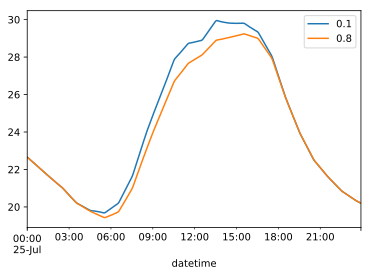

In [57]:
df_t2.loc['2012-07-25'].iloc[:,[0,-1]].plot()

Furthermore, when the $\Delta \alpha-\Delta T_{2}$ relations at the two peaking times are shown below, we can see the bi-linear relation based on the $T_{2,max}$ values for the July 2012 is actually composed of two linear relations at different times under different peaking scenarios. 

Text(0, 0.5, '$T_{2,max}$ ($^{\\circ}}$C)')

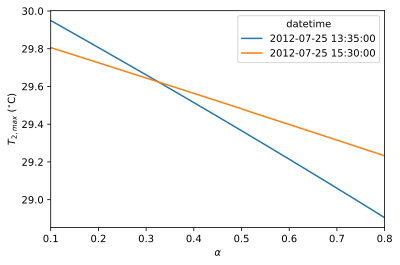

In [70]:
ax_t2_max=df_t2.loc['2012-07-25 13:35':'2012-07-25 15:30'].iloc[[0,-1]].T.plot()
ax_t2_max.set_xlabel(r'$\alpha$')
ax_t2_max.set_ylabel('$T_{2,max}$ ($^{\circ}}$C)')


## Background climate: air temperature

### Examine the monthly climatology of air temperature loaded from the sample dataset

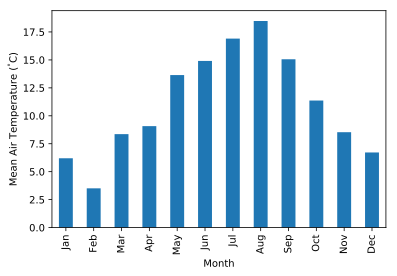

In [23]:
df_plot = df_forcing.Tair.iloc[:-1].resample('1m').mean()
ax_temp = df_plot.plot.bar(color='tab:blue')
ax_temp.set_xticklabels(df_plot.index.strftime('%b'))
ax_temp.set_ylabel('Mean Air Temperature ($^\degree$C)')
ax_temp.set_xlabel('Month')
ax_temp


### Construct a function to perform parallel `supy` simulation with specified `diff_airtemp_test`: the difference in air temperature between the one used in simulation and loaded from sample dataset.
*Note: forcing data `df_forcing` has different data structure from `df_state_init`; so we need to modify `run_supy_mgrids` to implement a `run_supy_mclims` for different climate scenarios*

Let's start the implementation of `run_supy_mclims` with a small problem of four forcing groups (i.e., climate scenarios), where the air temperatures differ from the baseline scenario with a constant bias.

In [24]:
# save loaded sample datasets
df_forcing_part_test = df_forcing.loc['2012 1':'2012 7'].copy()
df_state_init_test = df_state_init.copy()

In [25]:
# create a dict with four forcing conditions as a test
n_test = 4
list_TairDiff_test = np.linspace(0., 2, n_test).round(2)
dict_df_forcing_x = {
    tairdiff: df_forcing_part_test.copy()
    for tairdiff in list_TairDiff_test}
for tairdiff in dict_df_forcing_x:
    dict_df_forcing_x[tairdiff].loc[:, 'Tair'] += tairdiff

dd_forcing_x = {
    k: delayed(sp.run_supy)(df, df_state_init_test)[0]
    for k, df in dict_df_forcing_x.items()}


df_res_tairdiff_test0 = delayed(pd.concat)(
    dd_forcing_x,
    keys=list_TairDiff_test,
    names=['tairdiff'],
)

In [23]:
# test the performance of a parallel run
t0 = time()
df_res_tairdiff_test = df_res_tairdiff_test0\
    .compute(scheduler='threads')\
    .reset_index('grid', drop=True)
t1 = time()
t_par = t1 - t0
print(f'Execution time: {t_par:.2f} s')

Execution time: 13.41 s


In [26]:
# function for multi-climate `run_supy`
# wrapping the above code into one
def run_supy_mclims(df_state_init, dict_df_forcing_mclims):
    dd_forcing_x = {
        k: delayed(sp.run_supy)(df, df_state_init_test)[0]
        for k, df in dict_df_forcing_x.items()}
    df_output_mclims0 = delayed(pd.concat)(
        dd_forcing_x,
        keys=list(dict_df_forcing_x.keys()),
        names=['clm'],
    ).compute(scheduler='threads')
    df_output_mclims = df_output_mclims0.reset_index('grid', drop=True)

    return df_output_mclims

### Construct `dict_df_forcing_x` with multiple forcing `DataFrame`s

In [27]:
# save loaded sample datasets
df_forcing_part_test = df_forcing.loc['2012 1':'2012 7'].copy()
df_state_init_test = df_state_init.copy()

# create a dict with a number of forcing conditions
n_test = 24 # can be set with a smaller value to save simulation time
list_TairDiff_test = np.linspace(0., 2, n_test).round(2)
dict_df_forcing_x = {
    tairdiff: df_forcing_part_test.copy()
    for tairdiff in list_TairDiff_test}
for tairdiff in dict_df_forcing_x:
    dict_df_forcing_x[tairdiff].loc[:, 'Tair'] += tairdiff

### Perform simulations

In [28]:
# run parallel simulations using `run_supy_mclims`
t0 = time()
df_airtemp_test_x = run_supy_mclims(df_state_init_test, dict_df_forcing_x)
t1 = time()
t_par = t1-t0
print(f'Execution time: {t_par:.2f} s')

Execution time: 114.27 s


### Examine the results

In [ ]:
df_airtemp_test = df_airtemp_test_x.SUEWS.unstack(0)
df_temp_diff=df_airtemp_test.T2.transform(lambda x: x - df_airtemp_test.T2[0.0])
df_temp_diff_ana=df_temp_diff.loc['2012 7']
df_temp_diff_stat=df_temp_diff_ana.describe().loc[['max', 'mean', 'min']].T

In [ ]:
ax_temp_diff_stat=df_temp_diff_stat.plot()
ax_temp_diff_stat.set_ylabel('$\\Delta T_2$ ($^{\\circ}}$C)')
ax_temp_diff_stat.set_xlabel('$\\Delta T_{a}$ ($^{\\circ}}$C)')
ax_temp_diff_stat.set_aspect('equal')

The $T_{2}$ results indicate the increased $T_{a}$ has different impacts on the $T_{2}$ metrics (minimum, mean and maximum) but all increase linearly with $T_{a}.$ The maximum $T_{2}$ has the stronger response compared to the other metrics.